In [18]:
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

data = joblib.load("../benchmark_v2/variants.jl")

In [19]:
subset = data[data['svlen'] <= 50000].copy()
len(subset), len(data)

(34140, 34140)

In [20]:
import sys
import numpy as np

subset['signed_svlen'] = np.where(
    subset['svtype'] == 'DEL',
    -subset['svlen'],
    subset['svlen']
)

SZBINS_I = ['[50,100)', '[100,200)', '[200,300)', '[300,400)',
            '[400,600)', '[600,800)', '[800,1k)', '[1k,2.5k)', '[2.5k,5k)', '>=5k']
SZBINS_D = ['<=5k', '(5k,2.5k]', '(2.5k, 1k]', '(1k,800]', '(800,600]', '(600,400]',
            '(400,300]', '(300,200]', '(200,100]', '(100,50]']

SZBINMAX_I = [50, 100, 200, 300, 400, 600, 800, 1000, 2500, 5000, sys.maxsize]
SZBINMAX_D = [-1 * _ for _ in SZBINMAX_I[::-1]]

# Bin function
def assign_szbin(val):
    if val >= 0:
        return pd.cut([val], bins=SZBINMAX_I, labels=SZBINS_I, right=False)[0]
    else:
        return pd.cut([val], bins=SZBINMAX_D, labels=SZBINS_D, right=True)[0]
    
subset['signed_szbin'] = pd.Categorical(
    subset['signed_svlen'].apply(assign_szbin),
    categories=SZBINS_D + SZBINS_I, 
    ordered=True)

def get_vaf_bin(vaf, bins=[0, 0.05, 0.3, 1], labels=["<5%", "5%-30%", "Germline"]):
    """
    Bin VAFs and apply labels
    """
    return pd.cut(vaf, bins=bins, labels=labels) 
subset['VAF_bin'] = get_vaf_bin(subset['VAF_alt'])

In [21]:
x = subset['TRF'].value_counts()
x[True] / len(subset)

0.5773872290568248

In [22]:
x = subset['NumNeighbors'] != 0
x.sum() / len(subset)

0.3632396016403046

In [23]:
(x & subset['TRF']).sum() / len(subset)

0.3080257762155829

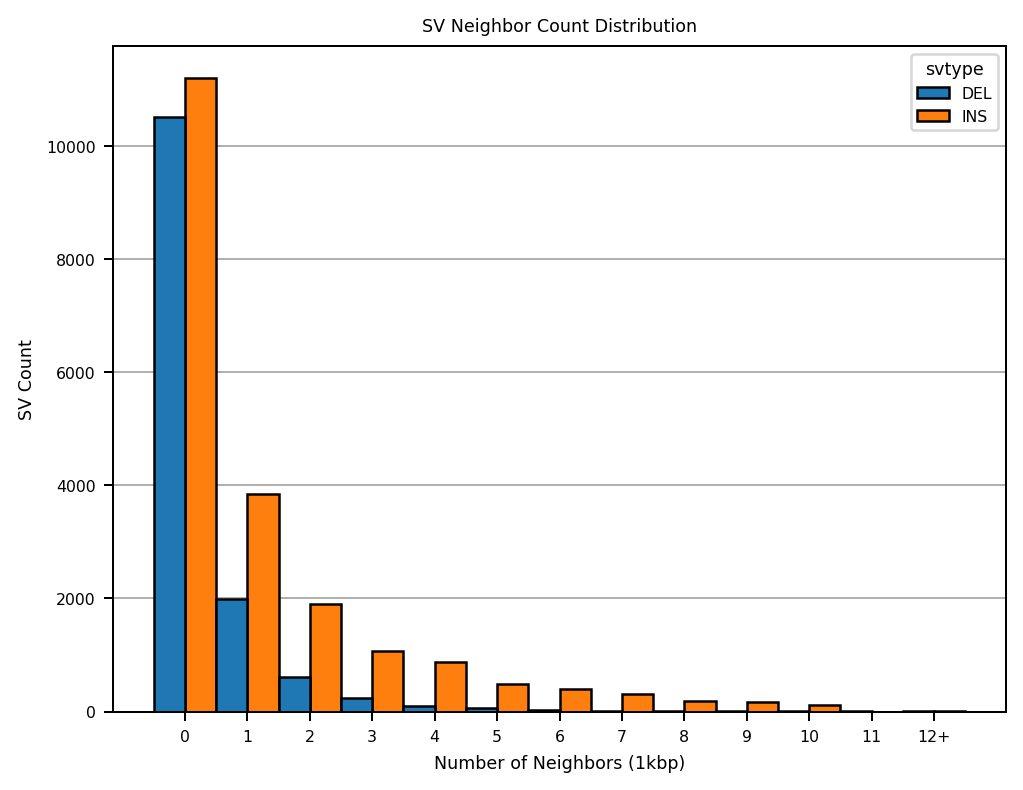

In [24]:
subset = subset.copy()
subset['NumNeighborsCapped'] = subset['NumNeighbors'].clip(upper=12)

plt.figure(dpi=180)
p = sb.histplot(data=subset, 
                x='NumNeighborsCapped', 
                hue='svtype',
                hue_order=['DEL', 'INS'],
                multiple="dodge", 
                binwidth=1,
                discrete=True,
                zorder=2,
                alpha=1)

plt.grid(axis='y', zorder=1)

# Update x-axis ticks to show '12+' for the last bin
xticks = list(range(0, 12)) + ['12+']
p.set_xticks(range(13))
p.set_xticklabels(xticks)
_ = p.set(title="SV Neighbor Count Distribution", xlabel="Number of Neighbors (1kbp)", ylabel="SV Count")

In [31]:

palette = sb.color_palette('deep', n_colors=8) 
palette

def scaled_fontsize(base_size, fig_width, reference_width=6.4, min_size=7):
    """
    Scales the base font size proportionally to figure width,
    but enforces a minimum font size.
    
    base_size: font size for reference_width (in inches)
    fig_width: actual figure width
    """
    scale = fig_width / reference_width
    return max(min_size, base_size * scale)


fig_width = 3.25
font_size = scaled_fontsize(base_size=12, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

# Figure 2 b - SV VAF Dist

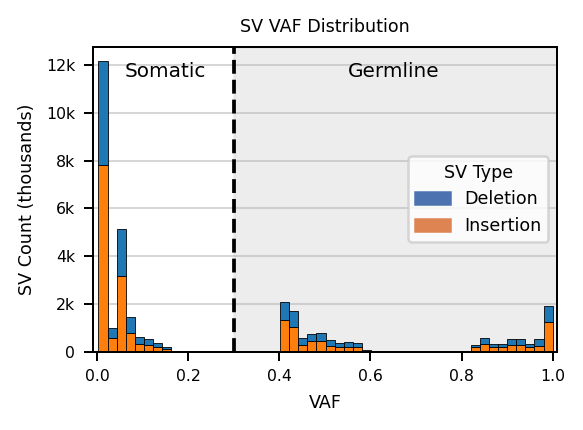

In [26]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       #figsize=(5 * len(files), 5), 
                       figsize=(3.25, 2.4), # For hifi.washu
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

p = sb.histplot(data=subset,
           x='VAF_alt',
           hue="svtype",
           hue_order=['DEL', 'INS'],
           multiple='stack',
           zorder=2,
           binwidth=0.02, 
           alpha=1,
           ax=ax[0][0],
           legend=True,
)

_ = p.set(title="SV VAF Distribution", ylabel="SV Count (thousands)", xlabel="VAF", xlim=(-0.01,1.01))
plt.grid(axis='y', alpha=0.50, zorder=1)

# Shade the area from 0.30 to 1.0
ax[0][0].axvspan(0.30, 1.1, color='lightgray', alpha=0.4, zorder=0)

# Draw the vertical line
ax[0][0].axvline(0.30, color='black', linestyle='--', linewidth=1.5, zorder=3)

# Add text labels for "Somatic" and "Germline"
ylim = ax[0][0].get_ylim()
y_text = ylim[1] * 0.95  # 95% up the Y-axis

ax[0][0].text(0.15, y_text, "Somatic", ha='center', va='top', fontsize=8)
ax[0][0].text(0.65, y_text, "Germline", ha='center', va='top', fontsize=8)

from matplotlib.patches import Patch
palette = sb.color_palette('deep', n_colors=2) 
# Move Legend
legend_handles = [
    Patch(color=palette[0], label='Deletion'),
    Patch(color=palette[1], label='Insertion'),
]

ax[0][0].legend(
    handles=legend_handles,
    loc='center right',
    bbox_to_anchor=(1.0, 0.5),
    bbox_transform=ax[0][0].transAxes,
    frameon=True,
    fontsize=7,
    title="SV Type",
)

# Define formatter function
def thousands_formatter(x, pos):
    return f"{int(x/1000)}k" if x >= 1000 else str(int(x))

# Apply to the axis
ax[0][0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.tight_layout()
plt.show()


In [27]:
(subset['VAF_alt'] >= 0.3).sum()

12756

In [28]:
(subset['VAF_alt'] >= 0.3).mean()

0.3736379613356766

# Figure 2 A - SV Size Dist

In [92]:
labels

('<5%', '5%-30%', 'Germline')

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1014/1776559846.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index=['signed_szbin', 'svtype'], columns='VAF_bin', values='count', fill_value=0)


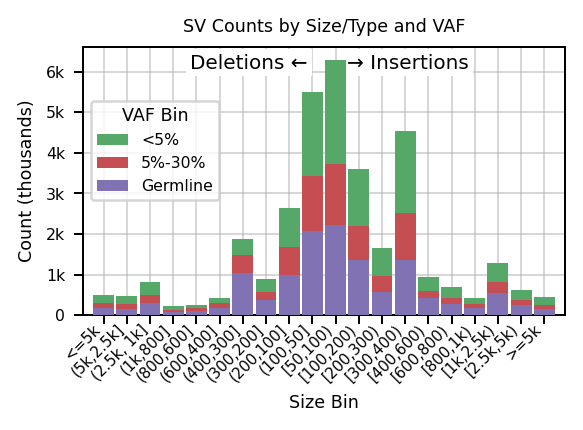

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(3.25, 2.4),
    squeeze=False,
    sharex='row',
    sharey='row',
    dpi=180,
)

ax = ax[0][0]

# Combine both DEL and INS types
subset_combined = subset[subset['svtype'].isin(['DEL', 'INS'])]

# Group and count
grouped = subset_combined.groupby(['signed_szbin', 'svtype', 'VAF_bin'], observed=True).size().reset_index(name='count')

# Pivot for stacking
pivot_df = grouped.pivot_table(index=['signed_szbin', 'svtype'], columns='VAF_bin', values='count', fill_value=0)

# Combine 'signed_szbin' and 'svtype' into a single x-axis position
pivot_df = pivot_df.reset_index()
pivot_df['x_pos'] = pivot_df['signed_szbin'].astype(str) + "_" + pivot_df['svtype'].astype(str)

# Create a mapping of x labels to positions
x_labels = pivot_df['x_pos']
x = range(len(x_labels))

# Choose a color palette
vaf_bins = pivot_df.columns.drop(['signed_szbin', 'svtype', 'x_pos'])
colors = sb.color_palette(palette[2:-3], n_colors=len(vaf_bins))

# Reverse stacking order, but keep original order for legend
stack_order = list(zip(vaf_bins, colors))[::-1]  # reverse for stacking

bottom = [0] * len(x)
for vaf, color in stack_order:
    heights = pivot_df[vaf].values
    ax.bar(x, heights, bottom=bottom, label=vaf, color=color, zorder=3, width=0.9)
    bottom = [b + h for b, h in zip(bottom, heights)]

# Ensure legend uses original (non-reversed) order
handles, labels = ax.get_legend_handles_labels()
# Zip and reorder based on original vaf_bins order
label_order = list(vaf_bins)
legend_items = sorted(zip(labels, handles), key=lambda x: label_order.index(x[0]))
labels, handles = zip(*legend_items)
ax.legend(handles, labels, title="VAF Bin", loc="lower left", bbox_to_anchor=(0, 0.4))

# X-axis setup
ax.set_xticks(x)
ax.set_xticklabels(pivot_df['signed_szbin'].astype(str), 
                   rotation=45, 
                   ha='right', 
                   fontsize=6)
ax.set_xlim(-0.9, 19.9)

# Axis labels and title
ax.set_title("SV Counts by Size/Type and VAF")
ax.set_ylabel("Count (thousands)")
ax.set_xlabel("Size Bin")

# Thousands formatter
def thousands_formatter(x, pos):
    #return f"{int(x):,}"
    return f"{int(x/1000)}k" if x >= 1000 else str(int(x))

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Grid and ticks
ax.grid(True, alpha=0.50, zorder=1)
ax.tick_params(axis='x', which='major', pad=-1)

# Annotations
ax.text(8.8, 6450, "Deletions ←", ha='right', va='top', zorder=2, fontsize=8,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2'))
ax.text(10.5, 6450, "→ Insertions", ha='left', va='top', zorder=2, fontsize=8,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2'))

plt.tight_layout()
plt.show()


In [46]:
subset[subset['svtype'] == 'DEL'].groupby(['szbin', 'VAF_bin']).size().unstack()

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1014/1011298287.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset[subset['svtype'] == 'DEL'].groupby(['szbin', 'VAF_bin']).size().unstack()


VAF_bin,<5%,5%-30%,Germline
szbin,,,
SNP,0,0,0
"[1,5)",0,0,0
"[5,10)",0,0,0
"[10,15)",0,0,0
"[15,20)",0,0,0
"[20,30)",0,0,0
"[30,40)",0,0,0
"[40,50)",0,0,0
"[50,100)",2080,1369,2062
